# [1주차] 심화 문제 

이번에는 32x32 흑백 둥물 이미지를 보고 어떤 동물인지 예측하는 문제 해결

GPU 개발 환경 세팅 (Nvidia Driver, CUDA Toolkit, cuDNN) 

### 기본 문제 추가 사항
1. Test data 준비
2. Cross Entropy Loss 함수 적용 (Classification Model)
3. Epoch에 따른 모델의 train 및 test 데이터셋에 대한 정확도 그리기(Plot)

### 심화 문제 추가 사항
- Dataset 및 activation 함수 변경
  - Dataset을 MNIST에서 [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)으로 변경해줍니다.
  - Activation 함수를 `nn.ReLU`에서 `nn.LeakyReLU`로 변경해줍니다.
  - 학습 인자는 `n_epochs` = 50, `batch_size` = 256로 설정합니다.
- CIFAR10의 입력 shape 확인
  - CIFAR10은 MNIST와 다른 입력 shape을 가지고 있습니다.
  - 입력 shape은 model을 선언할 때 중요하기 때문에 MNIST 실습 자료에서 사용한 방식과 똑같이 shape을 확인해주시면 됩니다.
- SGD와 Adam 성능 비교
  - 먼저 [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)을 사용하여 학습하는 코드를 구현합니다.
  - (Plot 1) SGD와 Adam을 학습시킨 후 각각의 epoch에 대한 train 정확도를 plot합니다.
- Leaky ReLU와 Sigmoid 성능 비교
  - Activation 함수가 `nn.Sigmoid`인 class를 새로 정의합니다.
  - (Plot 2) Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델들을 학습한 후, epoch에 따른 train 정확도를 비교합니다.
- Dropout을 적용한 이후의 generalization error 확인
  - PyTorch [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)을 leaky ReLU를 사용하는 MLP의 모든 layer에 적용한 class를 새로 정의합니다. Dropout 확률은 0.1로 설정합니다.
  - 학습 코드에서 다음 부분들을 추가해줍니다:
    - `model.train()`을 `for data in trainloader:` 이전 줄에 둡니다.
    - `trainloader`와 `testloader`에 대한 정확도를 계산하는 코드를 다음과 같이 변경합니다:
          
      ```python
       with torch.no_grad():
        model.eval()
        <기존 정확도 계산 코드>
      ```
          
  - (Plot 3) Adam optimizer를 가지고 dropout을 적용한 모델을 학습한 후, epoch에 따른 train과 test 정확도를 비교합니다.

다음은 필수 library들을 import

In [164]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 

dataset은 CIFAR10라는 유명한 dataset이 있습니다. 

이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [165]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='/workspace/data',
    train=True,
    download=True,
    transform=transform
)

trainset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /workspace/data
    Split: Train
    StandardTransform
Transform: ToTensor()

다음은 테스트 데이터셋을 준비합니다.

In [166]:
testset = torchvision.datasets.CIFAR10(
    root='/workspace/data',
    train=False,
    download=True,
    transform=transform
)

testset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /workspace/data
    Split: Test
    StandardTransform
Transform: ToTensor()

CIFAR10는 동물 사진과 어떤 동물을 의미하는지에 대한 label의 pair들로 구성되어있습니다.

이 때, 우리는 PyTorch model을 사용할 것이기 때문에 동물 사진들을 모두 tensor로 변환해야합니다.

이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.

우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

50000
torch.Size([3, 32, 32]) frog


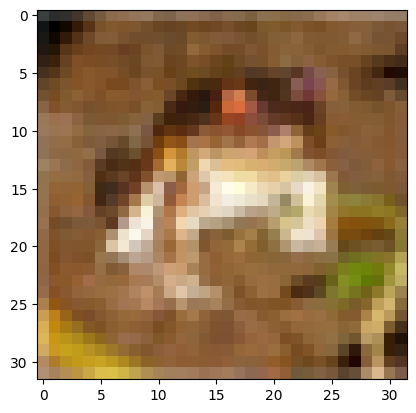

In [167]:
from matplotlib import pyplot as plt

img_index = 0

feature_name = {0:'airplane',
                1:'automobile',
                2:'bird',
                3:'cat',
                4:'deer',
                5:'dog',
                6:'frog',
                7:'horse',
                8:'ship',
                9:'truck'
               }

print(len(trainset)) # the size o training dataset 
print(trainset[img_index][0].shape, feature_name[trainset[img_index][1]]) # size spec, answer
plt.imshow(transforms.ToPILImage()(trainset[img_index][0])) # display an image

첫 번째 출력결과를 통해 우리는 5만장의 동물 사진 data가 있는 것을 알 수 있습니다.

그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 32, 32)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.

마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [168]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

다음은 테스트 테이터셋 로더 설정입니다.

In [169]:
batch_size = 256 

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.

부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.

우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

torch.Size([256, 3, 32, 32]) torch.Size([256])


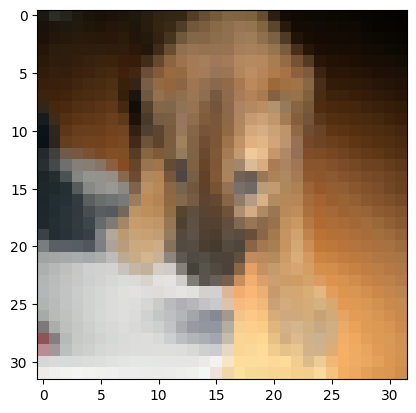

In [170]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape, labels.shape)
plt.imshow(transforms.ToPILImage()(images[img_index]))

`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.

위에서 batch size를 256로 설정했기 때문에 총 256개의 image와 label들이 있어야 합니다.

실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

아래는 Classification를 적용한 코드입니다.

In [198]:
from torch import nn

class Model_SGD(nn.Module):
  def __init__(self, input_dim, h_dim, output_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, h_dim)
    self.layer2 = nn.Linear(h_dim, h_dim)
    self.layer3 = nn.Linear(h_dim, output_dim)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

  def accuracy(self, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = self(inputs)
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

    return acc / cnt

class Model_Adam(Model_SGD):
  pass

class Model_Sigmoid(Model_SGD):
  def __init__(self, input_dim, h_dim, output_dim):
    super().__init__(input_dim, h_dim, output_dim)

    self.act = nn.Sigmoid()


model_SGD = Model_SGD(32 * 32 * 3, 4096, 10)
model_Adam = Model_Adam(32 * 32 * 3, 4096, 10)
model_Sig = Model_Sigmoid(32 * 32 * 3, 4096, 10)

criterion = nn.CrossEntropyLoss()

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.

여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.

`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.

이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.

이 역할을 수행하는 것이 바로 `torch.flatten`입니다.

우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [172]:
from torch.optim import SGD, Adam

lr = 0.001
model_SGD = model_SGD.to('cuda')

optimizer_SGD = SGD(model_SGD.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 

다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.

MNIST부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [173]:
trainset_acc = []
testset_acc = []

n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model_SGD.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_SGD(inputs) # prediction
    loss = criterion(preds, labels) # loss function
    loss.backward() # calculate the gradient 
    optimizer_SGD.step() # update weight

    total_loss += loss.item()

  trainset_acc.append(model_SGD.accuracy(trainloader))
  testset_acc.append(model_SGD.accuracy(testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | Accuracy: {testset_acc[-1]} ")

Epoch   0 | Loss: 449.2296075820923 | Accuracy: 0.1136 
Epoch   1 | Loss: 445.58589124679565 | Accuracy: 0.1574 
Epoch   2 | Loss: 442.281613111496 | Accuracy: 0.189 
Epoch   3 | Loss: 438.9695506095886 | Accuracy: 0.2158 
Epoch   4 | Loss: 435.5612244606018 | Accuracy: 0.2295 
Epoch   5 | Loss: 432.02850890159607 | Accuracy: 0.2549 
Epoch   6 | Loss: 428.4287021160126 | Accuracy: 0.2602 
Epoch   7 | Loss: 424.6930019855499 | Accuracy: 0.2722 
Epoch   8 | Loss: 420.9233977794647 | Accuracy: 0.2836 
Epoch   9 | Loss: 417.2703456878662 | Accuracy: 0.2843 
Epoch  10 | Loss: 413.7454402446747 | Accuracy: 0.2827 
Epoch  11 | Loss: 410.44458270072937 | Accuracy: 0.2944 
Epoch  12 | Loss: 407.3320281505585 | Accuracy: 0.2983 
Epoch  13 | Loss: 404.4406749010086 | Accuracy: 0.3009 
Epoch  14 | Loss: 401.7199388742447 | Accuracy: 0.2989 
Epoch  15 | Loss: 399.2356152534485 | Accuracy: 0.3066 
Epoch  16 | Loss: 396.8958361148834 | Accuracy: 0.3081 
Epoch  17 | Loss: 394.76071774959564 | Accuracy

In [174]:
model_Adam = model_Adam.to('cuda')

optimizer_adam = Adam(model_Adam.parameters(), lr=lr)

In [175]:
trainset_acc_adam = []
testset_acc_adam = []

n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model_Adam.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_Adam(inputs) # prediction
    loss = criterion(preds, labels) # loss function
    loss.backward() # calculate the gradient 
    optimizer_adam.step() # update weight

    total_loss += loss.item()

  trainset_acc_adam.append(model_Adam.accuracy(trainloader))
  testset_acc_adam.append(model_Adam.accuracy(testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | Accuracy: {testset_acc_adam[-1]} ")

Epoch   0 | Loss: 394.5070729255676 | Accuracy: 0.3781 
Epoch   1 | Loss: 328.27840518951416 | Accuracy: 0.3994 
Epoch   2 | Loss: 312.07880771160126 | Accuracy: 0.4207 
Epoch   3 | Loss: 298.1631203889847 | Accuracy: 0.3874 
Epoch   4 | Loss: 288.53056490421295 | Accuracy: 0.4604 
Epoch   5 | Loss: 280.8809025287628 | Accuracy: 0.4816 
Epoch   6 | Loss: 273.6010057926178 | Accuracy: 0.4987 
Epoch   7 | Loss: 267.1717200279236 | Accuracy: 0.4904 
Epoch   8 | Loss: 260.056240439415 | Accuracy: 0.4686 
Epoch   9 | Loss: 254.74845588207245 | Accuracy: 0.5069 
Epoch  10 | Loss: 248.99716925621033 | Accuracy: 0.4892 
Epoch  11 | Loss: 244.80723595619202 | Accuracy: 0.5146 
Epoch  12 | Loss: 239.17786574363708 | Accuracy: 0.4982 
Epoch  13 | Loss: 234.06549060344696 | Accuracy: 0.5166 
Epoch  14 | Loss: 230.59475326538086 | Accuracy: 0.5244 
Epoch  15 | Loss: 224.92464584112167 | Accuracy: 0.5241 
Epoch  16 | Loss: 220.96619242429733 | Accuracy: 0.5041 
Epoch  17 | Loss: 216.00491380691528 |

In [176]:
model_Sig = model_Sig.to('cuda')

optimizer_adam_sig = Adam(model_Sig.parameters(), lr=lr)

In [177]:
trainset_acc_sig = []
testset_acc_sig = []

n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model_Sig.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_Sig(inputs) # prediction
    loss = criterion(preds, labels) # loss function
    loss.backward() # calculate the gradient 
    optimizer_adam_sig.step() # update weight

    total_loss += loss.item()

  trainset_acc_sig.append(model_Sig.accuracy(trainloader))
  testset_acc_sig.append(model_Sig.accuracy(testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | Accuracy: {testset_acc_sig[-1]} ")

Epoch   0 | Loss: 443.76052737236023 | Accuracy: 0.214 
Epoch   1 | Loss: 385.04179787635803 | Accuracy: 0.3131 
Epoch   2 | Loss: 360.9533693790436 | Accuracy: 0.3547 
Epoch   3 | Loss: 344.21149373054504 | Accuracy: 0.3669 
Epoch   4 | Loss: 333.58985364437103 | Accuracy: 0.3977 
Epoch   5 | Loss: 324.1488378047943 | Accuracy: 0.4115 
Epoch   6 | Loss: 319.1957378387451 | Accuracy: 0.4083 
Epoch   7 | Loss: 312.28555369377136 | Accuracy: 0.4036 
Epoch   8 | Loss: 308.1752744913101 | Accuracy: 0.4308 
Epoch   9 | Loss: 304.4656537771225 | Accuracy: 0.4015 
Epoch  10 | Loss: 299.0700830221176 | Accuracy: 0.441 
Epoch  11 | Loss: 295.20530343055725 | Accuracy: 0.4521 
Epoch  12 | Loss: 292.85478389263153 | Accuracy: 0.417 
Epoch  13 | Loss: 286.04588985443115 | Accuracy: 0.4509 
Epoch  14 | Loss: 286.8052421808243 | Accuracy: 0.4675 
Epoch  15 | Loss: 279.21835482120514 | Accuracy: 0.458 
Epoch  16 | Loss: 276.9130926132202 | Accuracy: 0.45 
Epoch  17 | Loss: 272.98790287971497 | Accura

학습의 정확도를 Plot 1 합니다.

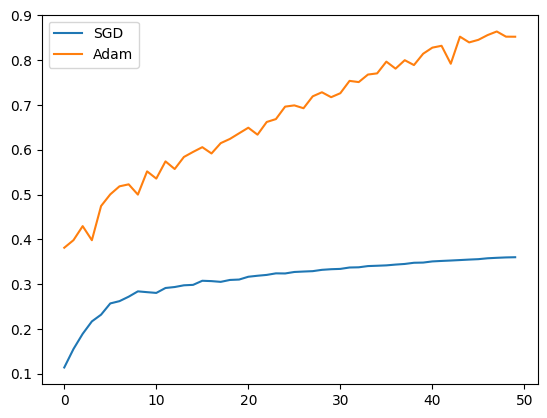

In [181]:
import numpy as np

def plot_acc(train_accs, train_accs_adam, label1='SGD', label2='Adam'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, train_accs_adam, label=label2)
  plt.legend()
  plt.show()

plot_acc(trainset_acc, trainset_acc_adam)


Plot 2 입니다.

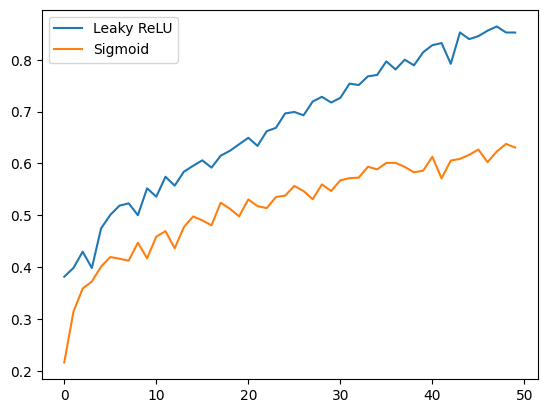

In [182]:
def plot_acc(train_accs, train_accs_adam, label1='Leaky ReLU', label2='Sigmoid'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, train_accs_adam, label=label2)
  plt.legend()
  plt.show()

plot_acc(trainset_acc_adam, trainset_acc_sig)


출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

In [201]:
class Model_Dropout(nn.Module):
    def __init__(self, input_dim, h_dim, output_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, h_dim)
        self.layer2 = nn.Linear(h_dim, h_dim)
        self.layer3 = nn.Linear(h_dim, output_dim)

        self.act = nn.LeakyReLU()
        
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.dropout(x)
        x = self.act(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)

        return x

    def accuracy(self, dataloader):
        cnt = 0
        acc = 0

        with torch.no_grad():
            self.eval()
            for data in dataloader:
                inputs, labels = data
                inputs, labels = inputs.to('cuda'), labels.to('cuda')

                preds = self(inputs)
                preds = torch.argmax(preds, dim=-1)

                cnt += labels.shape[0]
                acc += (labels == preds).sum().item()

        return acc / cnt
    

model_dropout = Model_Dropout(32 * 32 * 3, 4096, 10)

model_dropout = model_dropout.to('cuda')
optimizer_dropout = Adam(model_dropout.parameters(), lr=lr)

In [202]:
trainset_acc_dropout= []
testset_acc_dropout = []

n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0.
  model_dropout.train()
  for data in trainloader:
    model_dropout.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_dropout(inputs)   # prediction
    loss = criterion(preds, labels) # loss function
    loss.backward()                 # calculate the gradient 
    optimizer_dropout.step()        # update weight

    total_loss += loss.item()

  trainset_acc_dropout.append(model_dropout.accuracy(trainloader))
  testset_acc_dropout.append(model_dropout.accuracy(testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | Accuracy: {testset_acc_dropout[-1]} ")

Epoch   0 | Loss: 397.47470581531525 | Accuracy: 0.3542 
Epoch   1 | Loss: 333.29663717746735 | Accuracy: 0.4084 
Epoch   2 | Loss: 317.26735866069794 | Accuracy: 0.4361 
Epoch   3 | Loss: 305.8985501527786 | Accuracy: 0.4556 
Epoch   4 | Loss: 297.4466848373413 | Accuracy: 0.4601 
Epoch   5 | Loss: 291.20535957813263 | Accuracy: 0.4521 
Epoch   6 | Loss: 285.1799809932709 | Accuracy: 0.4612 
Epoch   7 | Loss: 279.3233873844147 | Accuracy: 0.4864 
Epoch   8 | Loss: 274.2369021177292 | Accuracy: 0.4944 
Epoch   9 | Loss: 271.3455843925476 | Accuracy: 0.4719 
Epoch  10 | Loss: 266.0998297929764 | Accuracy: 0.499 
Epoch  11 | Loss: 261.8818916082382 | Accuracy: 0.4898 
Epoch  12 | Loss: 256.9699877500534 | Accuracy: 0.5143 
Epoch  13 | Loss: 254.28797519207 | Accuracy: 0.5156 
Epoch  14 | Loss: 249.17700254917145 | Accuracy: 0.5204 
Epoch  15 | Loss: 247.67021095752716 | Accuracy: 0.5187 
Epoch  16 | Loss: 243.74012506008148 | Accuracy: 0.5196 
Epoch  17 | Loss: 240.1394430398941 | Accura

Plot 3 입니다.

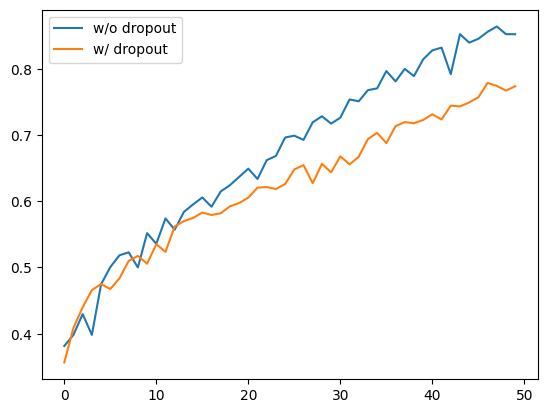

In [205]:
def plot_acc(train_accs1, train_accs2, label1='w/o dropout', label2='w/ dropout'):
  x = np.arange(len(train_accs1))

  plt.plot(x, train_accs1, label=label1)
  plt.plot(x, train_accs2, label=label2)
  plt.legend()
  plt.show()

plot_acc(trainset_acc_adam, trainset_acc_dropout)


[4.630764484405518, 9.485382080078125, -7.569339752197266, -6.427402973175049, -5.218293190002441, -7.166942596435547, -17.6710205078125, -13.66021728515625, 16.009857177734375, 4.205760478973389]
ship
ship


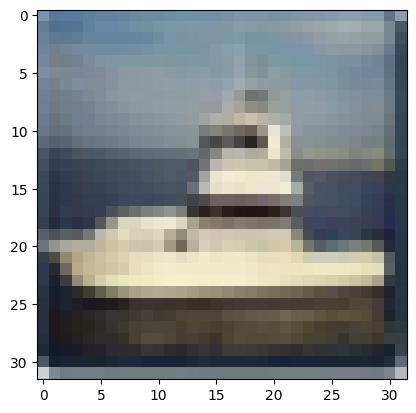

In [215]:
import random

idx = random.randint(0, len(trainset)-1) 

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda') # load data on GPU

inference = model_dropout(x)
data = inference.detach().cpu().tolist()[0]
max_idx = data.index(max(data))

print(data)
print(feature_name[max_idx]) # inference in GPU

print(feature_name[trainset[idx][1]]) # get the answer in CPU
plt.imshow(transforms.ToPILImage()(trainset[idx][0]))